In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math
from math import log, exp, sqrt, isnan
import pandas as pd

#### Here we define fits and variables

In [3]:
dt = .001 # Time differential

t0 =  0  # intial time
tF = 60  # final time

"""B0 → 71.5717, dBG → 0.065535, deltaB → 0.226845, deltaG → 0.104574,
deltaM → 0.0817739, deltaP → 0.107014, dG → 0.179527, fM → 7.04933, hB → 0.000108336,
hG → 2.34565 × 10-11, lambda → 5.37004, lambdaG → 2.13042, m → 1.80624,
muG → 1.2265 × 107, rB → 6.16541, rG → 0.262815, sigmaA → 0.135469, sigmaN → 0.409708"""

# Constants/fits emaileld
B01 = 72.559
d_BG1 = 0.0635991
delta_B1 = 0.236724
delta_G1 = 0.0982312
delta_M1 = 0.205638
delta_P1 = 0.151396
d_G1 = 0.322589
d_M1 = d_G1 #0.00245009 
d_P1 = d_G1 #0.0161013  
#f_M1 = .5 
f_M1 = 11.0984         # why is f_M this high? it's a probability, so shouldn't it be <= 1?
h_B1 = 0.0000941496
h_G1 = 1.68872*(10**-11)
lam1 = 5.33041
lam_g1 = 2.13481
m1 = 1.82175
mu1 = 1.2274*(10**7)
r_B1 = 6.13599
r_G1 = 0.274329

# Contstants/fits from Mathematica code
B02 = 71.5717
d_BG2 = 0.065535
delta_B2 = 0.226845
delta_G2 = 0.104574
delta_M2 = 0.0817739
delta_P2 = 0.107014
d_G2 = 0.179527
f_M2 = 7.04933
h_B2 = 0.000108336
h_G2 = 2.34565 * (10 ** -11)
lam2 = 5.37004
lam_g2 = 2.13042
m2 = 1.80624
mu2 = 1.2265 * (10 ** 7)
r_B2 = 6.16541
r_G2 = 0.262815

sigma_A2 = 0.135469;
sigma_N2 = 0.409708;


             # 0    1      2         3         4         5         6     7     8     9     10    11      12  13   14    15    16        17
vInit = tuple((B02, d_BG2, delta_B2, delta_G2, delta_M2, delta_P2, d_G2, f_M2, h_B2, h_G2, lam2, lam_g2, m2, mu2, r_B2, r_G2, sigma_A2, sigma_N2))
vNames = tuple(("B0", "d_BG", "delta_B", "delta_G", "delta_M", "delta_P", "d_G", "f_M", "h_B", "h_G", "lam", "lam_g", "m", "mu", "r_B", "r_G", "sigma_A", "sigma_N"))

v = tuple((71.57166043918619, 0.06526503272575228, 0.22636846237957514, 0.10298869550085069, 0.08070940045960347, 0.1068673524930725, 0.17955508653054128, 7.049281361575644, 9.289061730407464e-05, 1.1219171234849999e-11, 5.36976024615705, 2.131315018358811, 1.8060858194634375, 12265000.0, 6.164622539434759, 0.25358161014096414, 0.13617930656738325, 0.4103559570923567))

# Sets if r_Gk is constant or if r_Gk = r_G*sqrt(k)
variabler_G = True

# Intial conditions
A0 = 1
A_g0 = 0

# the number of steps
N = int(round((tF-t0)/dt))

Aarr = np.zeros(N + 1)
Aarr[0] = A0
A_garr = np.zeros(N + 1)
A_garr[0] = A_g0
Barr = np.zeros(N + 1)
Barr[0] = vInit[0]

Garr = np.zeros((4, N + 1))
Marr = np.zeros((4, N + 1))
Parr = np.zeros((4, N + 1))

Gtotarr = np.zeros(N + 1)
Mtotarr = np.zeros(N + 1)
Ptotarr = np.zeros(N + 1)

tarr = np.zeros(N + 1)
tarr[0] = t0


#### Here we set up the arrrays for approximating the model

In [4]:
def reInitArrs(B0):
    global Aarr, A_garr, Barr, Garr, Marr, Parr, Gtotarr, Mtotarr, Ptotarr, tarr
    
    Aarr = np.zeros(N + 1)
    Aarr[0] = A0
    A_garr = np.zeros(N + 1)
    A_garr[0] = A_g0
    Barr = np.zeros(N + 1)
    Barr[0] = B0

    Garr = np.zeros((4, N + 1))
    Marr = np.zeros((4, N + 1))
    Parr = np.zeros((4, N + 1))

    Gtotarr = np.zeros(N + 1)
    Mtotarr = np.zeros(N + 1)
    Ptotarr = np.zeros(N + 1)

    tarr = np.zeros(N + 1)
    tarr[0] = t0


#### Here we have all the equations for the affinity model as laid out in the writeup

In [5]:
#Eqn 1
def dAdt(lam, m, A):
    return (-1 * (lam + m) * A)

#Eqn 2
def dA_gdt(lam_g, m, A, A_g):
    return m * A - lam_g * A_g

#Eqn 3
def dBdt(r_B, h_B, delta_B, d_BG, A, B):
    return r_B * A / (h_B + A) * B - (delta_B + d_BG) * B

    #Eqn 4 and 5
# k is the index on G
#G[k]'[t] == If[k == 1, 1, 0] * dBG * B[t] + (1 - muG / (1 + muG) * If[k == nA, 0, 1]) * rG * Sqrt[k] * Ag[t] / (hG + Ag[t]) * G[k][t] - (deltaG + dG * rG * Sqrt[k] * Ag[t] / (hG + Ag[t])) * G[k][t] + muG / (1 + muG) * 
           # If[k == 1, 0, 1] * rG * Sqrt[k - 1] * Ag[t] / (hG + Ag[t]) * G[k - 1][t], {k, 1, nA}],            
def dG_kdt(k, d_BG, d_G, h_G, delta_G, mu, r_G, A_g, B, G_k, G_kmin1):
    if(k == 1): c0 = 1
    else: c0 = 0
        
    # modifiy n here
    if(k == 3): c1 = 0
    else: c1 = 1
        
    if(k == 1): c2 = 0
    else: c2 = 1
    
    return c0 * d_BG * B + (1 - mu / (1 + mu) * c1) * r_G * math.sqrt(k) * A_g / (h_G + A_g) * G_k - (delta_G + d_G * r_G * math.sqrt(k) * A_g / (h_G + A_g)) * G_k + mu / (1 + mu) * c2 * r_G * math.sqrt(k-1) * A_g / (h_G + A_g) * G_kmin1
    
#Eqn 6
# fM * Exp[-aM * (k - 1)] / (1 + fM * Exp[-aM * (k - 1)]) * dG *G[k][t] * rG * Sqrt[k] * Ag[t] / (hG + Ag[t]) - deltaM * M[k][t],
def dM_kdt(k, f_M, d_G, r_G, h_G, delta_M, A_g, G_k, M_k):
    a_M = .5 # ???? or is it fit?
    return f_M * math.exp(-1 * a_M * (k - 1)) / (1 + f_M * math.exp(-1 * a_M * (k - 1))) * d_G * G_k * r_G * math.sqrt(k) * A_g / (h_G + A_g) - delta_M * M_k

#Eqn 7
#Table[P[k]'[t] == (1 / (1 + fM * Exp[-aM * (k - 1)])) * dG * G[k][t] * rG * Sqrt[k] * Ag[t] / (hG + Ag[t]) - deltaP * P[k][t], {k, 1, nA}]
def dP_kdt(k, f_M, d_G, r_G, h_G, delta_P, A_g, G_k, P_k):
    a_M = .5 
    return (1 / (1 + f_M * math.exp(-a_M * (k - 1)) ) ) * d_G * G_k * r_G * math.sqrt(k) * A_g / (h_G + A_g) - delta_P * P_k


#### The main function of the model. 
It utilizes the Euler method for approximating systems of differential equations:
https://en.wikipedia.org/wiki/Euler_method
There may be limitations (esp w/ small time steps) when using this method

In [6]:
# Euler method
def euler(v):
    global Aarr, A_garr, Barr, tarr, Garr, Parr, Marr, Gtotarr, Mtotarr, Ptotarr
    
    (B0, d_BG, delta_B, delta_G, delta_M, delta_P, d_G, f_M, h_B, h_G, lam, lam_g, m, mu, r_B, r_G, sigma_A, sigma_N) = v
    reInitArrs(B0)
    
    for i in range(1, N + 1):
        #f_M = .5
        A = Aarr[i - 1]
        A_g = A_garr[i - 1]
        B = Barr[i - 1]
        t = tarr[i - 1]
        Aarr[i] = A + dt * dAdt(lam, m, A)
        A_garr[i] = A_g + dt * dA_gdt(lam_g, m, A, A_g)
        Barr[i] = B + dt * dBdt(r_B, h_B, delta_B, d_BG, A, B)
    
        for k in range(1, 4):
            G_k = Garr[k, i - 1]
            G_kmin1 = Garr[k - 1, i - 1]
            P_k = Parr[k, i - 1]
            M_k = Marr[k, i - 1]
            Garr[k, i] = G_k + dt * dG_kdt(k, d_BG, d_G, h_G, delta_G, mu, r_G, A_g, B, G_k, G_kmin1)
            Marr[k, i] = M_k + dt * dM_kdt(k, f_M, d_G, r_G, h_G, delta_M, A_g, G_k, M_k)
            Parr[k, i] = P_k + dt * dP_kdt(k, f_M, d_G, r_G, h_G, delta_P, A_g, G_k, P_k)

            Gtotarr[i] += Garr[k, i]
            Ptotarr[i] += Parr[k, i]
            Mtotarr[i] += Marr[k, i]
            
    
        tarr[i] = t + dt
    
    for i in range(1, len(Barr)):
        Barr[i]+= B0

#### Here, we extract expiremental data from csv's to plot w/ model

In [7]:
# Cell counts for  PBs GCBs and MCs
csv = pd.read_csv('data-Bcell-dynamics-edited-permouse.csv', index_col = 'day', names=['day','PB','GC','MC'])
Stimes = csv.index.values[1:-1].astype('int')
Spb = csv.PB.values[1:-1].astype('double')
Sgc = csv.GC.values[1:-1].astype('double')
Smc = csv.MC.values[1:-1].astype('double')

# Cell counts for PC's
xlsx = pd.read_excel('LLPC_total_numbers.xlsx', index_col = 'day', names =['day','zero','one','two','three'])
Stimes2 = xlsx.index.values[0:4].astype('int')
Stimes2 = np.repeat(Stimes2, 4)
Spc = np.zeros(16)
for i in range (0, 4):
    Spc[4*i + 0] = xlsx.zero.values[i].astype('double')
    Spc[4*i + 1] = xlsx.one.values[i].astype('double')
    Spc[4*i + 2] = xlsx.two.values[i].astype('double')
    Spc[4*i + 3] = xlsx.three.values[i].astype('double')

# Cell affinities
csv2 = pd.read_csv('data-IgHg2A10_affinity-cleaned.csv', index_col = 'day', names = ['day', 'AA', 'celltype', 'mouse'])
csv2.sort_values(by = 'day')
Sapbt, Sagct, Samct, Sapct = [], [], [], []
Sapb, Sagc, Samc, Sapc = [], [], [], []

for i in range(len(csv2.index)):
    if(csv2.celltype.values[i] == "PB"):
        Sapbt.append(int(csv2.index.values[i]))
        Sapb.append(float(csv2.AA.values[i]))
    if(csv2.celltype.values[i] == "GC"):
        Sagct.append(int(csv2.index.values[i]))
        Sagc.append(float(csv2.AA.values[i]))
    if(csv2.celltype.values[i] == "MC" or csv2.celltype.values[i] == "MBC"):
        Samct.append(int(csv2.index.values[i]))
        Samc.append(float(csv2.AA.values[i]))
    if(csv2.celltype.values[i] == "PC"):
        Sapct.append(int(csv2.index.values[i]))
        Sapc.append(float(csv2.AA.values[i]))

In [8]:
def calcAA():
    global Garr, Gtotarr, Marr, Mtotarr, Parr, Ptotarr, Barr
    
    BAarr, GAarr, MAarr, PAarr = np.zeros((N + 1)), np.zeros((N + 1)), np.zeros((N + 1)), np.zeros((N + 1))
    avgPBA = 0
    k = 0
    for i in Sapb:
        if(math.isnan(i)):
            continue
        avgPBA += i
        k += 1
    avgPBA = avgPBA / k
    
    for i in range(N+1):
        
        avgG, avgM, avgP = 0, 0, 0
        for j in range(1, 4):
            avgG += Garr[j, i] * j
            avgM += Marr[j, i] * j
            avgP += Parr[j, i] * j
            
        totG = Gtotarr[i]
        totM = Mtotarr[i]
        totP = Ptotarr[i]
        if(totG == 0): totG = 1
        if(totM == 0): totM = 1
        if(totP == 0): totP = 1
        avgG = avgG/totG
        avgM = avgM/totM
        avgP = avgP/totP 
    
        BAarr[i] = avgPBA 
        GAarr[i] = avgG
        MAarr[i] = avgM
        PAarr[i] = avgP
        
    return [BAarr, GAarr, MAarr, PAarr]


In [9]:
def NLL(v):
    
    euler(v)
    
    # Scatter number, model number of cells
    snt = [Stimes, Stimes, Stimes, Stimes2]
    sn = [Spb, Sgc, Smc, Spc]
    mn = [Barr, Gtotarr, Mtotarr, Ptotarr]
    
    sat = [Sapbt, Sagct, Samct, Sapct]
    sa = [Sapb, Sagc, Samc, Sapc]
    ma = calcAA()
    
    sum1 = 0
    n1 = 0
    for j in range(4):
        k = 0
        for i in snt[j]:
            actual = sn[j][k]
            predicted = mn[j][int(i/dt)]
            k += 1
            if(actual <= 0 or predicted <= 0 or math.isnan(actual)): continue
            n1 += 1
            sum1 += ( (math.log(actual, 10) - math.log(predicted, 10)) ** 2 ) / (2 * (v[-1] ** 2))
            #print(j, i, actual, predicted, sum1)
    
    sum2 = 0       
    n2 = 0
    for j in range(4):
        k = 0
        for i in sat[j]:
            actual = sa[j][k]
            predicted = ma[j][int(i/dt)]
            k += 1
            if(math.isnan(actual)): continue
            n2 += 1
            sum2 += ((actual- predicted) ** 2) / (2 * (v[-2] ** 2))
            #print(j, i, actual, predicted, sum2)
        
    #n1 = len(Stimes)
    #n2 = len(Sapbt) # This does make it so that we are using n1/n2 unrelated to what we have summed over
    
    
    #print(sum1)
    #print(sum2)
        
    # Also, the base for logs just changes here for no reason????
    return (sum1 + sum2 + (n1 * math.log(v[-1])) + (n2 * math.log(v[-2])))

print(NLL(vInit))

-76.34287972274825


#### Here, we run the model and graph the results

(71.63707635430293, 0.08880205309837655, 0.20163423092566682, 0.14067127107412047, 0.14848556347171632, 0.18084010224502817, 0.2575298716112511, 7.276666445646691, 9.28905908097106e-05, 7.791712348500018e-13, 5.773477012829015, 2.4799302013384414, 1.9251641085463678, 12265000.0, 6.4458354098294315, 0.27629541457708956, 0.41734070749486885, 0.6245891619522298)
-79.7649274476764


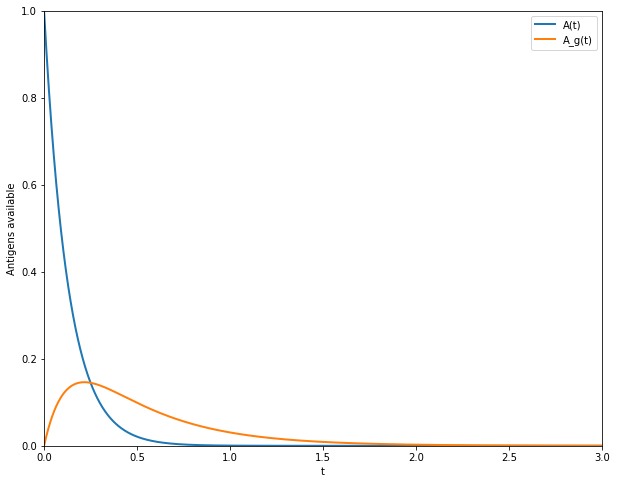

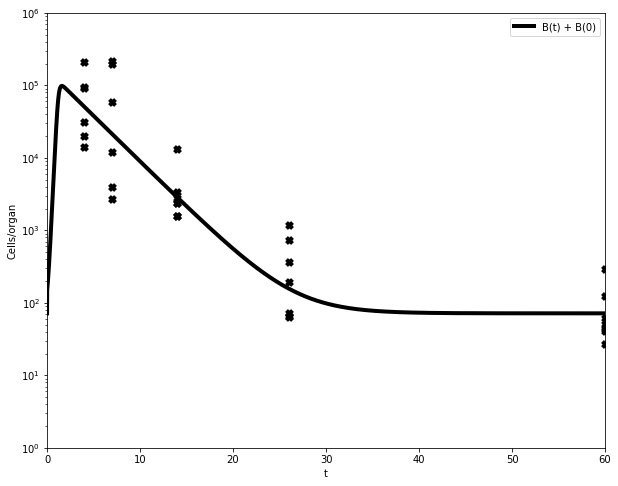

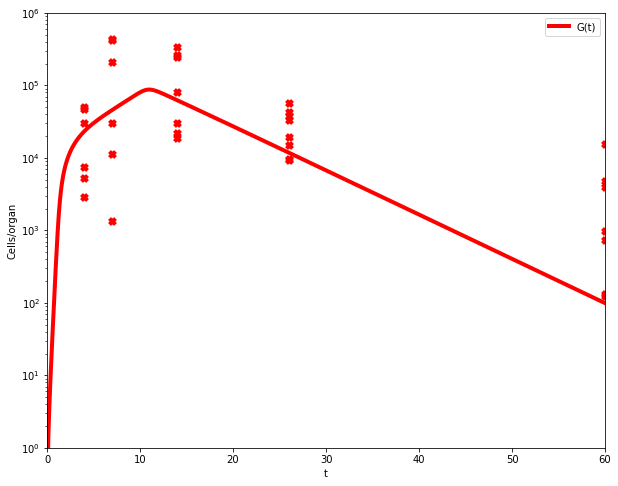

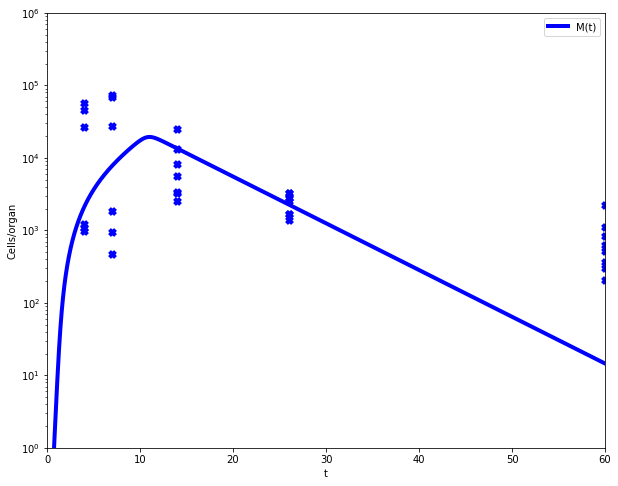

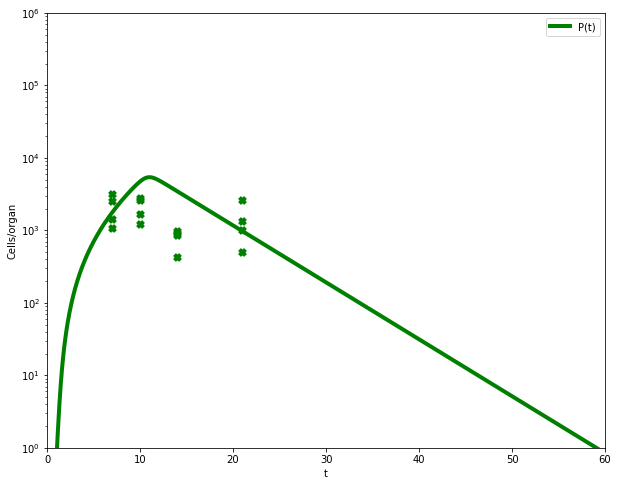

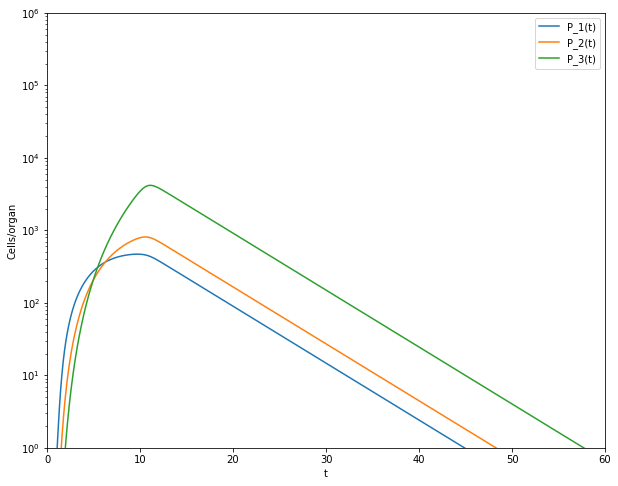

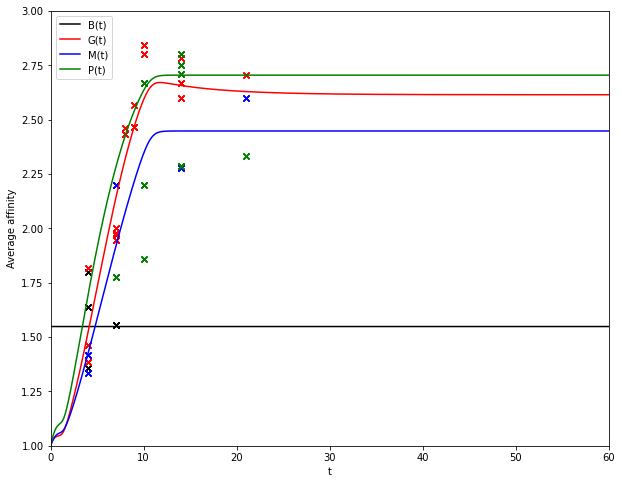

In [16]:
# Call the function to run the model so we can graph

# here are the variables w/ the lowest SSR i got with gradient descent. SSR: 5.148666e+11
# (71.59205434857685, 0.06806932130591119, 0.2104126492314999, 0.09116913023495661, 0.08178938340112435, 0.10701968476189978, 0.17310394397234516, 7.049336642090847, 7.10792496e-05, 1.8724084774374178e-11, 5.252497501199031, 2.1041403856757808, 1.7679069783484835, 12265000.0, 6.313904193296472, 0.19885356550859085, 0.135469, 0.409708)
vTW = tuple((71.63707635429844, 0.08880205307601731, 0.20163423104856087, 0.1406712718515763, 0.14848556439026647, 0.1808401022604593, 0.25752987161035007, 7.276666445646036, 9.289061730407464e-05, 1.1219171234849999e-11, 5.773477012859556, 2.479930201384509, 1.9251641085744973, 12265000.0, 6.445835409792564, 0.2762954144238309, 0.4173407077560404, 0.6245891618508299))

print(v)
print(NLL(v))

# Graph of antigens available
fig1 = plt.figure()
fig1.set_size_inches(10,8)

plt.plot(tarr, Aarr, label = "A(t)", linewidth = 2)
plt.plot(tarr, A_garr, label = "A_g(t)", linewidth = 2)

plt.xlabel("t")
plt.ylabel("Antigens available")

plt.axis([t0, 3, 0, 1])

plt.legend()
plt.show()

#Plasmablasts graph

fig2 = plt.figure()
fig2.set_size_inches(10,8)

plt.plot(tarr, Barr, linewidth = 4, label = "B(t) + B(0)", color = 'black')
plt.scatter(Stimes, Spb, linewidth = 4, marker = 'x', color = 'black')

plt.xlabel("t")
plt.ylabel("Cells/organ")
plt.xscale("linear")
plt.yscale("log")
plt.axis([t0, tF, 1, 10**6])

plt.legend()
plt.show()

# GC B cells graph

fig3 = plt.figure()
fig3.set_size_inches(10,8)

plt.plot(tarr, Gtotarr, linewidth = 4, label = "G(t)", color = 'red')
plt.scatter(Stimes, Sgc, linewidth = 4, marker = 'x', color = 'red')

plt.xlabel("t")
plt.ylabel("Cells/organ")
plt.xscale("linear")
plt.yscale("log")
plt.axis([t0, tF, 1, 10**6])

plt.legend()
plt.show()

# MCB cells graph

fig4 = plt.figure()
fig4.set_size_inches(10,8)

plt.plot(tarr, Mtotarr, linewidth = 4, label = "M(t)", color = 'blue')
plt.scatter(Stimes, Smc, linewidth = 4, marker = 'x', color = 'blue')

plt.xlabel("t")
plt.ylabel("Cells/organ")
plt.xscale("linear")
plt.yscale("log")
plt.axis([t0, tF, 1, 10**6])

plt.legend()
plt.show()

# Plasma cells graph

fig5 = plt.figure()
fig5.set_size_inches(10,8)

plt.plot(tarr, Ptotarr, linewidth = 4, label = "P(t)", color = 'green')
plt.scatter(Stimes2, Spc, linewidth = 4, marker = 'x', color = 'green')

plt.xlabel("t")
plt.ylabel("Cells/organ")
plt.xscale("linear")
plt.yscale("log")
plt.axis([t0, tF, 1, 10**6])

plt.legend()
plt.show()

# Graph of GC B cell affinities 

fig6 = plt.figure()
fig6.set_size_inches(10,8)


plt.plot(tarr, Parr[1], label = "P_1(t)")
plt.plot(tarr, Parr[2], label = "P_2(t)")
plt.plot(tarr, Parr[3], label = "P_3(t)")
plt.xlabel("t")
plt.ylabel("Cells/organ")
plt.yscale("log")
plt.axis([t0, tF, 1, 10**6])

plt.legend()
plt.show

# Average affinities
fig7 = plt.figure()
fig7.set_size_inches(10,8)

plt.plot(tarr, calcAA()[0], label = "B(t)", color = 'black')
plt.scatter(Sapbt, Sapb, marker = 'x', color = 'black')
plt.plot(tarr, calcAA()[1], label = "G(t)", color = 'red')
plt.scatter(Sagct, Sagc, marker = 'x', color = 'red')
plt.plot(tarr, calcAA()[2], label = "M(t)", color = 'blue')
plt.scatter(Samct, Samc, marker = 'x', color = 'blue')
plt.plot(tarr, calcAA()[3], label = "P(t)", color = 'green')
plt.scatter(Sapct, Sapc, marker = 'x', color = 'green')


plt.xlabel("t")
plt.ylabel("Average affinity")
plt.axis([t0, tF, 1.0, 3.0])

plt.legend()
plt.show()

#### Here, we start fitting variables to the data using gradient descent

It is currently set to use SSR for this. This does not seem to be a good function to use for fitting the graph, as fits with less SSR don't look as good as the init fit.

In [14]:
learningRate = 1

def grad(v):
    nll1 = NLL(v)
    
    nlllist.append(nll1)
    print(nll1)
    
    grad = tuple(())
    
    for i in range(0, len(v)):
        if(vNames[i] not in vNames):
            grad += tuple((0.0,))
            continue
        
        dV = .01 * 10 ** (int(log(v[i], 10))) 
        v2 = v[0:i] + tuple((v[i] + dV, )) + v[i+1:]
        dnll = NLL(v2) - nll1
        
        print('  dV of ', dV, ' on ', vNames[i], ' got nll of', dnll + nll1, ' for a dnll ', dnll)
        
        grad += tuple((dnll/dV, ))
    
    print('  grad =', grad)
    
    return grad
    
def deltaV(grad, v):
    gMax = max(np.absolute(grad))
    gMin = min(np.absolute(grad))
        
    deltaV = tuple(())
    for i in range(0, len(v)):
        dV = .01 * 10 ** (int(log(v[i], 10))) 
        if (grad[i] == 0.0): deltaV += tuple((0.0,))
        else: deltaV += tuple(((-1 * (grad[i]/abs(grad[i])) * (abs(grad[i]/gMax)) * dV * learningRate),))
    
    return deltaV
        
              
def gradDescent(v):
    strikes = 0 # just like baseball, if it misses 3 times we stop
    for i in range (1, 100):
        nllOld = NLL(v)
        
        print(i)
        print('v = ', v)
        
        dV = deltaV(grad(v), v)
        print('dV = ', dV)
        
        newV = tuple(())
        
        for j in range(0, len(v)):
            newV += tuple((v[j] + dV[j], ))
        
        nllNew = NLL(newV)
        
        if(nllNew > nllOld): 
            if(strikes == 0): goodV = v
            strikes += 1
            if(strikes >= 2):
                return goodV
            
        else: 
            strikes = 0
        v = newV
            
    
    return v

nlllist = list((NLL(vTW),))
v = gradDescent(vTW)

print(nlllist)

1
v =  (71.63707635429844, 0.08880205307601731, 0.20163423104856087, 0.1406712718515763, 0.14848556439026647, 0.1808401022604593, 0.25752987161035007, 7.276666445646036, 9.289061730407464e-05, 1.1219171234849999e-11, 5.773477012859556, 2.479930201384509, 1.9251641085744973, 12265000.0, 6.445835409792564, 0.2762954144238309, 0.4173407077560404, 0.6245891618508299)
-69.57781523548783
  dV of  0.1  on  B0  got nll of -69.62428466144436  for a dnll  -0.046469425956530586
  dV of  0.001  on  d_BG  got nll of -69.82282442143841  for a dnll  -0.24500918595057897
  dV of  0.01  on  delta_B  got nll of -68.37889698321973  for a dnll  1.1989182522681006
  dV of  0.01  on  delta_G  got nll of -61.71493724595345  for a dnll  7.8628779895343826
  dV of  0.01  on  delta_M  got nll of -60.43401608139473  for a dnll  9.143799154093102
  dV of  0.01  on  delta_P  got nll of -69.39267127654358  for a dnll  0.18514395894425206
  dV of  0.01  on  d_G  got nll of -69.5836378049315  for a dnll  -0.005822569

4
v =  (71.63707635429873, 0.08880205307747178, 0.20163423104134098, 0.1406712718044668, 0.14848556433538654, 0.1808401022593704, 0.2575298716103872, 7.2766664456460735, 9.289061565628087e-05, 9.11917123485e-12, 5.773477012857653, 2.4799302013814573, 1.9251641085727587, 12265000.0, 6.445835409794873, 0.27629541443549954, 0.41734070774115867, 0.6245891618571537)
-70.65345235225297
  dV of  0.1  on  B0  got nll of -70.698747417242  for a dnll  -0.04529506498903402
  dV of  0.001  on  d_BG  got nll of -70.88952152634633  for a dnll  -0.23606917409335892
  dV of  0.01  on  delta_B  got nll of -69.45973257552097  for a dnll  1.1937197767319958
  dV of  0.01  on  delta_G  got nll of -62.91474364412065  for a dnll  7.738708708132322
  dV of  0.01  on  delta_M  got nll of -61.61779638736502  for a dnll  9.035655964887951
  dV of  0.01  on  delta_P  got nll of -70.47890703497988  for a dnll  0.1745453172730862
  dV of  0.01  on  d_G  got nll of -70.66002455218995  for a dnll  -0.006572199936982

7
v =  (71.63707635429898, 0.0888020530787425, 0.20163423103490427, 0.1406712717627631, 0.14848556428668302, 0.18084010225843197, 0.2575298716104229, 7.276666445646106, 9.289061420406533e-05, 8.81917123485e-12, 5.773477012855977, 2.4799302013788034, 1.9251641085712243, 12265000.0, 6.4458354097969055, 0.2762954144454215, 0.41734070772782295, 0.6245891618627178)
-70.82170139663519
  dV of  0.1  on  B0  got nll of -70.86680747990805  for a dnll  -0.04510608327285581
  dV of  0.001  on  d_BG  got nll of -71.05634272199629  for a dnll  -0.23464132536109616
  dV of  0.01  on  delta_B  got nll of -69.6289245179439  for a dnll  1.1927768786912907
  dV of  0.01  on  delta_G  got nll of -63.10297657806841  for a dnll  7.718724818566784
  dV of  0.01  on  delta_M  got nll of -61.803427544080236  for a dnll  9.018273852554955
  dV of  0.01  on  delta_P  got nll of -70.6488510342207  for a dnll  0.17285036241449347
  dV of  0.01  on  d_G  got nll of -70.8283908365081  for a dnll  -0.006689439872914

10
v =  (71.63707635429924, 0.08880205307997438, 0.20163423102863093, 0.14067127172219143, 0.14848556423926992, 0.18084010225752564, 0.2575298716104583, 7.276666445646138, 9.289061279298233e-05, 8.51917123485e-12, 5.773477012854349, 2.4799302013762334, 1.925164108569733, 12265000.0, 6.44583540979888, 0.27629541445496913, 0.41734070771480763, 0.6245891618681224)
-70.99424273326233
  dV of  0.1  on  B0  got nll of -71.03915346247601  for a dnll  -0.044910729213683
  dV of  0.001  on  d_BG  got nll of -71.22741117490543  for a dnll  -0.2331684416431017
  dV of  0.01  on  delta_B  got nll of -69.8024711642231  for a dnll  1.1917715690392185
  dV of  0.01  on  delta_G  got nll of -63.296176749713595  for a dnll  7.69806598354873
  dV of  0.01  on  delta_M  got nll of -61.993931381543575  for a dnll  9.00031135171875
  dV of  0.01  on  delta_P  got nll of -70.8231414534464  for a dnll  0.17110127981592882
  dV of  0.01  on  d_G  got nll of -71.00105245791045  for a dnll  -0.00680972464812157

13
v =  (71.63707635429945, 0.08880205308116729, 0.20163423102252248, 0.1406712716827593, 0.14848556419315642, 0.18084010225665145, 0.2575298716104934, 7.27666644564617, 9.289061142326594e-05, 8.21917123485e-12, 5.773477012852769, 2.4799302013737488, 1.925164108568285, 12265000.0, 6.445835409800796, 0.2762954144641431, 0.4173407077021161, 0.6245891618733665)
-71.17134370919531
  dV of  0.1  on  B0  got nll of -71.21605226173527  for a dnll  -0.044708552539958646
  dV of  0.001  on  d_BG  got nll of -71.40299114289563  for a dnll  -0.23164743370031715
  dV of  0.01  on  delta_B  got nll of -69.98064518320871  for a dnll  1.1906985259866047
  dV of  0.01  on  delta_G  got nll of -63.49465942025803  for a dnll  7.676684288937281
  dV of  0.01  on  delta_M  got nll of -62.18961615130321  for a dnll  8.9817275578921
  dV of  0.01  on  delta_P  got nll of -71.0020493816315  for a dnll  0.16929432756381857
  dV of  0.01  on  d_G  got nll of -71.17827698526649  for a dnll  -0.00693327607118021

16
v =  (71.63707635429967, 0.08880205308232107, 0.2016342310165805, 0.14067127164447446, 0.14848556414835215, 0.18084010225580943, 0.2575298716105282, 7.276666445646202, 9.289061009515873e-05, 7.91917123485e-12, 5.773477012851237, 2.479930201371348, 1.92516410856688, 12265000.0, 6.445835409802652, 0.2762954144729439, 0.41734070768975184, 0.6245891618784495)
-71.35329878794634
  dV of  0.1  on  B0  got nll of -71.39779784111919  for a dnll  -0.044499053172842196
  dV of  0.001  on  d_BG  got nll of -71.5833736645305  for a dnll  -0.2300748765841547
  dV of  0.01  on  delta_B  got nll of -70.16374700766642  for a dnll  1.1895517802799276
  dV of  0.01  on  delta_G  got nll of -63.698772291447  for a dnll  7.654526496499344
  dV of  0.01  on  delta_M  got nll of -62.39082173313578  for a dnll  8.962477054810563
  dV of  0.01  on  delta_P  got nll of -71.18587343061168  for a dnll  0.16742535733466468
  dV of  0.01  on  d_G  got nll of -71.36035913362308  for a dnll  -0.007060345676734414

19
v =  (71.63707635429988, 0.0888020530834356, 0.20163423101080663, 0.14067127160734488, 0.1484855641048671, 0.18084010225499958, 0.2575298716105627, 7.2766664456462316, 9.289060880891233e-05, 7.61917123485e-12, 5.773477012849753, 2.4799302013690316, 1.9251641085655191, 12265000.0, 6.44583540980445, 0.27629541448137235, 0.4173407076777184, 0.6245891618833703)
-71.54043343007314
  dV of  0.1  on  B0  got nll of -71.58471510364194  for a dnll  -0.04428167356880408
  dV of  0.001  on  d_BG  got nll of -71.76888038870885  for a dnll  -0.22844695863571474
  dV of  0.01  on  delta_B  got nll of -70.35210882045169  for a dnll  1.1883246096214464
  dV of  0.01  on  delta_G  got nll of -63.90890020802706  for a dnll  7.631533222046073
  dV of  0.01  on  delta_M  got nll of -62.597924206851246  for a dnll  8.94250922322189
  dV of  0.01  on  delta_P  got nll of -71.37494367706907  for a dnll  0.1654897530040671
  dV of  0.01  on  d_G  got nll of -71.54762465051192  for a dnll  -0.00719122043878

22
v =  (71.63707635430009, 0.08880205308451071, 0.20163423100520259, 0.14067127157137904, 0.14848556406271166, 0.18084010225422195, 0.2575298716105968, 7.276666445646261, 9.289060756478796e-05, 7.31917123485e-12, 5.773477012848318, 2.4799302013668, 1.9251641085642022, 12265000.0, 6.445835409806188, 0.2762954144894291, 0.4173407076660196, 0.6245891618881283)
-71.7331087027357
  dV of  0.1  on  B0  got nll of -71.77716449226594  for a dnll  -0.04405578953023337
  dV of  0.001  on  d_BG  got nll of -71.95986812309616  for a dnll  -0.2267594203604517
  dV of  0.01  on  delta_B  got nll of -70.54609929168564  for a dnll  1.1870094110500702
  dV of  0.01  on  delta_G  got nll of -64.12547075440872  for a dnll  7.607637948326982
  dV of  0.01  on  delta_M  got nll of -62.81134129098723  for a dnll  8.921767411748476
  dV of  0.01  on  delta_P  got nll of -71.56962634557186  for a dnll  0.16348235716384352
  dV of  0.01  on  d_G  got nll of -71.74043493262832  for a dnll  -0.00732622989261244

25
v =  (71.6370763543003, 0.08880205308554627, 0.2016342309997701, 0.14067127153658565, 0.14848556402189675, 0.1808401022534766, 0.25752987161063057, 7.27666644564629, 9.289060636305716e-05, 7.01917123485e-12, 5.773477012846932, 2.4799302013646534, 1.9251641085629296, 12265000.0, 6.445835409807866, 0.27629541449711503, 0.41734070765465947, 0.6245891618927225)
-71.93172679041398
  dV of  0.1  on  B0  got nll of -71.97554748950333  for a dnll  -0.04382069908935193
  dV of  0.001  on  d_BG  got nll of -72.1567342710566  for a dnll  -0.2250074806426312
  dV of  0.01  on  delta_B  got nll of -70.74612924481445  for a dnll  1.1855975455995207
  dV of  0.01  on  delta_G  got nll of -64.34896095929915  for a dnll  7.582765831114827
  dV of  0.01  on  delta_M  got nll of -63.03153885505597  for a dnll  8.900187935358005
  dV of  0.01  on  delta_P  got nll of -71.77032940784852  for a dnll  0.161397382565454
  dV of  0.01  on  d_G  got nll of -71.93919254548842  for a dnll  -0.00746575507444902

28
v =  (71.6370763543005, 0.08880205308654213, 0.20163423099451103, 0.14067127150297387, 0.14848556398243373, 0.18084010225276353, 0.2575298716106639, 7.276666445646317, 9.289060520400255e-05, 6.71917123485e-12, 5.7734770128455954, 2.4799302013625915, 1.9251641085617017, 12265000.0, 6.445835409809483, 0.2762954145044309, 0.417340707643642, 0.6245891618971521)
-72.13673762869576
  dV of  0.1  on  B0  got nll of -72.18031323767471  for a dnll  -0.04357560897895496
  dV of  0.001  on  d_BG  got nll of -72.35992337572534  for a dnll  -0.22318574702958927
  dV of  0.01  on  delta_B  got nll of -70.95265848096372  for a dnll  1.1840791477320352
  dV of  0.01  on  delta_G  got nll of -64.57990538455236  for a dnll  7.5568322441433935
  dV of  0.01  on  delta_M  got nll of -63.25903877219987  for a dnll  8.877698856495883
  dV of  0.01  on  delta_P  got nll of -71.9775093240921  for a dnll  0.15922830460365844
  dV of  0.01  on  d_G  got nll of -72.14434786855156  for a dnll  -0.0076102398558

31
v =  (71.63707635430067, 0.08880205308749811, 0.20163423098942737, 0.14067127147055328, 0.14848556394433457, 0.18084010225208277, 0.2575298716106968, 7.2766664456463435, 9.289060408791856e-05, 6.41917123485e-12, 5.7734770128443085, 2.479930201360615, 1.925164108560519, 12265000.0, 6.44583540981104, 0.27629541451137773, 0.4173407076329716, 0.624589161901416)
-72.34864695000506
  dV of  0.1  on  B0  got nll of -72.39196656801823  for a dnll  -0.043319618013171635
  dV of  0.001  on  d_BG  got nll of -72.56993505573143  for a dnll  -0.22128810572637292
  dV of  0.01  on  delta_B  got nll of -71.1662040603716  for a dnll  1.1824428896334638
  dV of  0.01  on  delta_G  got nll of -64.81890595882292  for a dnll  7.529740991182138
  dV of  0.01  on  delta_M  got nll of -63.49442846038224  for a dnll  8.854218489622824
  dV of  0.01  on  delta_P  got nll of -72.19167922026435  for a dnll  0.15696772974071393
  dV of  0.01  on  d_G  got nll of -72.35640715544434  for a dnll  -0.0077602054392

34
v =  (71.63707635430085, 0.08880205308841405, 0.20163423098452113, 0.14067127143933386, 0.14848556390761175, 0.18084010225143435, 0.25752987161072927, 7.27666644564637, 9.289060301511247e-05, 6.11917123485e-12, 5.773477012843071, 2.4799302013587234, 1.9251641085593814, 12265000.0, 6.445835409812536, 0.27629541451795653, 0.41734070762265285, 0.6245891619055133)
-72.56802612132915
  dV of  0.1  on  B0  got nll of -72.61107781782691  for a dnll  -0.04305169649775564
  dV of  0.001  on  d_BG  got nll of -72.78733370686228  for a dnll  -0.21930758553313012
  dV of  0.01  on  delta_B  got nll of -71.38735043430971  for a dnll  1.1806756870194448
  dV of  0.01  on  delta_G  got nll of -65.06664403193172  for a dnll  7.501382089397438
  dV of  0.01  on  delta_M  got nll of -63.73837257119486  for a dnll  8.829653550134296
  dV of  0.01  on  delta_P  got nll of -72.41341888824837  for a dnll  0.15460723308078173
  dV of  0.01  on  d_G  got nll of -72.57594239042895  for a dnll  -0.0079162690

37
v =  (71.63707635430102, 0.08880205308928976, 0.20163423097979444, 0.14067127140932612, 0.1484855638722784, 0.1808401022508183, 0.25752987161076124, 7.276666445646395, 9.289060198590531e-05, 5.81917123485e-12, 5.773477012841885, 2.4799302013569173, 1.9251641085582896, 12265000.0, 6.445835409813969, 0.27629541452416845, 0.4173407076126905, 0.6245891619094429)
-72.79552427987252
  dV of  0.1  on  B0  got nll of -72.83829494034626  for a dnll  -0.042770660473735234
  dV of  0.001  on  d_BG  got nll of -73.01276046778878  for a dnll  -0.21723618791625654
  dV of  0.01  on  delta_B  got nll of -71.61676195156758  for a dnll  1.1787623283049413
  dV of  0.01  on  delta_G  got nll of -65.32389528553034  for a dnll  7.471628994342183
  dV of  0.01  on  delta_M  got nll of -63.99162743894507  for a dnll  8.80389684092745
  dV of  0.01  on  delta_P  got nll of -72.64338712391381  for a dnll  0.15213715595871236
  dV of  0.01  on  d_G  got nll of -72.803603448546  for a dnll  -0.00807916867347

40
v =  (71.63707635430119, 0.0888020530901251, 0.20163423097524957, 0.14067127138054114, 0.1484855638383484, 0.18084010225023467, 0.2575298716107926, 7.276666445646419, 9.289060100063318e-05, 5.51917123485e-12, 5.773477012840749, 2.479930201355197, 1.9251641085572437, 12265000.0, 6.445835409815341, 0.2762954145300148, 0.41734070760308967, 0.6245891619132038)
-73.0318834487584
  dV of  0.1  on  B0  got nll of -73.0743585879083  for a dnll  -0.04247513914990009
  dV of  0.001  on  d_BG  got nll of -73.24694812129079  for a dnll  -0.21506467253237815
  dV of  0.01  on  delta_B  got nll of -71.85519844664236  for a dnll  1.176685002116045
  dV of  0.01  on  delta_G  got nll of -65.59154836005561  for a dnll  7.4403350887027955
  dV of  0.01  on  delta_M  got nll of -64.25505911823998  for a dnll  8.776824330518423
  dV of  0.01  on  delta_P  got nll of -72.88233709768434  for a dnll  0.1495463510740649
  dV of  0.01  on  d_G  got nll of -73.04013324371752  for a dnll  -0.00824979495911293

43
v =  (71.63707635430136, 0.08880205309091983, 0.20163423097088887, 0.14067127135299057, 0.1484855638058364, 0.18084010224968342, 0.2575298716108234, 7.276666445646443, 9.289060005964848e-05, 5.21917123485e-12, 5.773477012839664, 2.4799302013535627, 1.9251641085562445, 12265000.0, 6.445835409816651, 0.276295414535497, 0.4173407075938557, 0.6245891619167948)
-73.2779575653585
  dV of  0.1  on  B0  got nll of -73.32012109860955  for a dnll  -0.04216353325104194
  dV of  0.001  on  d_BG  got nll of -73.49073984871283  for a dnll  -0.21278228335432914
  dV of  0.01  on  delta_B  got nll of -72.1035348772799  for a dnll  1.1744226880786073
  dV of  0.01  on  delta_G  got nll of -65.87062837824874  for a dnll  7.407329187109767
  dV of  0.01  on  delta_M  got nll of -64.52966614571181  for a dnll  8.74829141964669
  dV of  0.01  on  delta_P  got nll of -73.1311357074585  for a dnll  0.146821857900008
  dV of  0.01  on  d_G  got nll of -73.28638680049536  for a dnll  -0.008429235136858892
 

46
v =  (71.63707635430151, 0.08880205309167381, 0.20163423096671487, 0.14067127132668675, 0.1484855637747579, 0.18084010224916458, 0.2575298716108536, 7.276666445646464, 9.28905991633215e-05, 4.91917123485e-12, 5.773477012838631, 2.479930201352014, 1.9251641085552922, 12265000.0, 6.445835409817898, 0.2762954145406165, 0.4173407075849943, 0.6245891619202146)
-73.53473671697782
  dV of  0.1  on  B0  got nll of -73.57657067800582  for a dnll  -0.041833961028004296
  dV of  0.001  on  d_BG  got nll of -73.74511311141572  for a dnll  -0.21037639443790113
  dV of  0.01  on  delta_B  got nll of -72.36278635600868  for a dnll  1.1719503609691344
  dV of  0.01  on  delta_G  got nll of -66.1623270106855  for a dnll  7.372409706292316
  dV of  0.01  on  delta_M  got nll of -64.8166086074732  for a dnll  8.718128109504619
  dV of  0.01  on  delta_P  got nll of -73.39078823291544  for a dnll  0.1439484840623777
  dV of  0.01  on  d_G  got nll of -73.54335554879384  for a dnll  -0.00861883181602252

49
v =  (71.63707635430164, 0.08880205309238681, 0.20163423096273023, 0.14067127130164264, 0.14848556374512933, 0.18084010224867814, 0.25752987161088314, 7.276666445646486, 9.289059831204219e-05, 4.61917123485e-12, 5.77347701283765, 2.479930201350552, 1.9251641085543874, 12265000.0, 6.445835409819081, 0.2762954145453751, 0.41734070757651154, 0.624589161923462)
-73.80337841211261
  dV of  0.1  on  B0  got nll of -73.84486259941484  for a dnll  -0.041484187302231135
  dV of  0.001  on  d_BG  got nll of -74.01121045728311  for a dnll  -0.20783204517050535
  dV of  0.01  on  delta_B  got nll of -72.63414047632796  for a dnll  1.1692379357846505
  dV of  0.01  on  delta_G  got nll of -66.46804141739254  for a dnll  7.335336994720066
  dV of  0.01  on  delta_M  got nll of -65.11724575331456  for a dnll  8.686132658798044
  dV of  0.01  on  delta_P  got nll of -73.66247015427199  for a dnll  0.14090825784062133
  dV of  0.01  on  d_G  got nll of -73.81219867672039  for a dnll  -0.008820264607

52
v =  (71.63707635430177, 0.08880205309305864, 0.20163423095893776, 0.14067127127787218, 0.14848556371696817, 0.18084010224822414, 0.257529871610912, 7.276666445646507, 9.289059750622229e-05, 4.3191712348500005e-12, 5.773477012836722, 2.4799302013491764, 1.92516410855353, 12265000.0, 6.4458354098202, 0.27629541454977474, 0.41734070756841396, 0.6245891619265357)
-74.0852485179542
  dV of  0.1  on  B0  got nll of -74.12636004663202  for a dnll  -0.04111152867781698
  dV of  0.001  on  d_BG  got nll of -74.29037983866104  for a dnll  -0.20513132070684037
  dV of  0.01  on  delta_B  got nll of -72.91899967151517  for a dnll  1.1662488464390321
  dV of  0.01  on  delta_G  got nll of -66.78942544086064  for a dnll  7.295823077093559
  dV of  0.01  on  delta_M  got nll of -65.43318539446216  for a dnll  8.652063123492042
  dV of  0.01  on  delta_P  got nll of -73.94756881710748  for a dnll  0.13767970084671788
  dV of  0.01  on  d_G  got nll of -74.09428418279543  for a dnll  -0.00903566484

55
v =  (71.6370763543019, 0.08880205309368905, 0.2016342309553405, 0.14067127125539008, 0.1484855636902931, 0.18084010224780253, 0.2575298716109401, 7.2766664456465255, 9.28905967462978e-05, 4.0191712348500005e-12, 5.773477012835846, 2.4799302013478877, 1.9251641085527214, 12265000.0, 6.445835409821255, 0.27629541455381756, 0.4173407075607084, 0.624589161929434)
-74.38197573006649
  dV of  0.1  on  B0  got nll of -74.4226884546899  for a dnll  -0.04071272462341824
  dV of  0.001  on  d_BG  got nll of -74.5842282411449  for a dnll  -0.20225251107841302
  dV of  0.01  on  delta_B  got nll of -73.21903763463351  for a dnll  1.1629380954329775
  dV of  0.01  on  delta_G  got nll of -67.12845803808828  for a dnll  7.253517691978203
  dV of  0.01  on  delta_M  got nll of -65.7663498614549  for a dnll  8.615625868611588
  dV of  0.01  on  delta_P  got nll of -74.2477388853953  for a dnll  0.134236844671193
  dV of  0.01  on  d_G  got nll of -74.39124351016423  for a dnll  -0.0092677800977440

58
v =  (71.63707635430202, 0.08880205309427783, 0.20163423095194166, 0.14067127123421222, 0.1484855636651242, 0.18084010224741331, 0.25752987161096746, 7.276666445646544, 9.289059603273212e-05, 3.7191712348500006e-12, 5.773477012835024, 2.479930201346686, 1.9251641085519615, 12265000.0, 6.4458354098222435, 0.276295414557506, 0.41734070755340236, 0.6245891619321557)
-74.69552539184198
  dV of  0.1  on  B0  got nll of -74.73580915035006  for a dnll  -0.040283758508081746
  dV of  0.001  on  d_BG  got nll of -74.89469433828518  for a dnll  -0.19916894644319427
  dV of  0.01  on  delta_B  got nll of -73.53627587045278  for a dnll  1.1592495213891993
  dV of  0.01  on  delta_G  got nll of -67.4875365031892  for a dnll  7.207988888652778
  dV of  0.01  on  delta_M  got nll of -66.11906574340114  for a dnll  8.576459648440846
  dV of  0.01  on  delta_P  got nll of -74.56497751723984  for a dnll  0.13054787460214357
  dV of  0.01  on  d_G  got nll of -74.70504560738331  for a dnll  -0.0095202

61
v =  (71.63707635430215, 0.08880205309482475, 0.20163423094874475, 0.14067127121435558, 0.14848556364148313, 0.18084010224705643, 0.257529871610994, 7.276666445646562, 9.289059536601964e-05, 3.4191712348500007e-12, 5.773477012834257, 2.479930201345572, 1.925164108551251, 12265000.0, 6.445835409823167, 0.2762954145608428, 0.417340707546504, 0.624589161934699)
-75.02830165720958
  dV of  0.1  on  B0  got nll of -75.06812126049844  for a dnll  -0.03981960328886203
  dV of  0.001  on  d_BG  got nll of -75.2241490029727  for a dnll  -0.1958473457631129
  dV of  0.01  on  delta_B  got nll of -73.87318977851533  for a dnll  1.1551118786942567
  dV of  0.01  on  delta_G  got nll of -67.86960623463904  for a dnll  7.1586954225705455
  dV of  0.01  on  delta_M  got nll of -66.49418862997169  for a dnll  8.534113027237893
  dV of  0.01  on  delta_P  got nll of -74.9017284413817  for a dnll  0.12657321582787517
  dV of  0.01  on  d_G  got nll of -75.03809945420157  for a dnll  -0.00979779699198

64
v =  (71.63707635430224, 0.08880205309532956, 0.20163423094575353, 0.14067127119583855, 0.1484855636193934, 0.18084010224673186, 0.25752987161101965, 7.276666445646578, 9.289059474669051e-05, 3.1191712348500007e-12, 5.773477012833543, 2.479930201344545, 1.9251641085505904, 12265000.0, 6.445835409824024, 0.27629541456383117, 0.4173407075400221, 0.6245891619370624)
-75.38329233498172
  dV of  0.1  on  B0  got nll of -75.42260618520677  for a dnll  -0.03931385022505651
  dV of  0.001  on  d_BG  got nll of -75.57553774681156  for a dnll  -0.19224541182984467
  dV of  0.01  on  delta_B  got nll of -74.23285927879918  for a dnll  1.1504330561825356
  dV of  0.01  on  delta_G  got nll of -68.27834593188024  for a dnll  7.104946403101479
  dV of  0.01  on  delta_M  got nll of -66.8952808513971  for a dnll  8.488011483584614
  dV of  0.01  on  delta_P  got nll of -75.26102957412448  for a dnll  0.12226276085723953
  dV of  0.01  on  d_G  got nll of -75.3933994683938  for a dnll  -0.010107133

67
v =  (71.63707635430232, 0.08880205309579198, 0.2016342309429721, 0.14067127117868117, 0.14848556359888063, 0.1808401022464395, 0.2575298716110444, 7.276666445646594, 9.289059417531674e-05, 2.8191712348500008e-12, 5.773477012832885, 2.4799302013436066, 1.9251641085499804, 12265000.0, 6.445835409824814, 0.27629541456647455, 0.41734070753396635, 0.6245891619392436)
-75.76428010497682
  dV of  0.1  on  B0  got nll of -75.803038254375  for a dnll  -0.03875814939817701
  dV of  0.001  on  d_BG  got nll of -75.95258832177086  for a dnll  -0.18830821679404153
  dV of  0.01  on  delta_B  got nll of -74.6191888317698  for a dnll  1.145091273207015
  dV of  0.01  on  delta_G  got nll of -68.71843969889551  for a dnll  7.045840406081311
  dV of  0.01  on  delta_M  got nll of -67.32687214786813  for a dnll  8.43740795710869
  dV of  0.01  on  delta_P  got nll of -75.6467283778421  for a dnll  0.11755172713472462
  dV of  0.01  on  d_G  got nll of -75.77473762351872  for a dnll  -0.0104575185418

70
v =  (71.63707635430241, 0.08880205309621174, 0.20163423094040492, 0.14067127116290543, 0.148485563579973, 0.18084010224617927, 0.2575298716110682, 7.276666445646608, 9.289059365252009e-05, 2.519171234850001e-12, 5.7734770128322825, 2.4799302013427567, 1.925164108549422, 12265000.0, 6.445835409825535, 0.2762954145687772, 0.41734070752834745, 0.6245891619412409)
-76.17616091783512
  dV of  0.1  on  B0  got nll of -76.21430225232571  for a dnll  -0.03814133449058943
  dV of  0.001  on  d_BG  got nll of -76.36012348148118  for a dnll  -0.18396256364606245
  dV of  0.01  on  delta_B  got nll of -75.03723976547049  for a dnll  1.138921152364631
  dV of  0.01  on  delta_G  got nll of -69.19599083720796  for a dnll  6.980170080627161
  dV of  0.01  on  delta_M  got nll of -67.7948552327234  for a dnll  8.381305685111712
  dV of  0.01  on  delta_P  got nll of -76.06380667990234  for a dnll  0.11235423793277732
  dV of  0.01  on  d_G  got nll of -76.18702335359856  for a dnll  -0.01086243576

73
v =  (71.6370763543025, 0.08880205309658855, 0.20163423093805707, 0.14067127114853575, 0.14848556356270204, 0.180840102245951, 0.257529871611091, 7.2766664456466215, 9.289059317898305e-05, 2.219171234850001e-12, 5.773477012831737, 2.4799302013419955, 1.9251641085489157, 12265000.0, 6.445835409826188, 0.276295414570744, 0.41734070752317737, 0.624589161943052)
-76.62544346941141
  dV of  0.1  on  B0  got nll of -76.66289145975048  for a dnll  -0.03744799033907498
  dV of  0.001  on  d_BG  got nll of -76.8045512552423  for a dnll  -0.17910778583089382
  dV of  0.01  on  delta_B  got nll of -75.49375281738031  for a dnll  1.1316906520310965
  dV of  0.01  on  delta_G  got nll of -69.71917770659957  for a dnll  6.906265762811842
  dV of  0.01  on  delta_M  got nll of -68.30711119244233  for a dnll  8.318332276969073
  dV of  0.01  on  delta_P  got nll of -76.51889054186213  for a dnll  0.10655292754927359
  dV of  0.01  on  d_G  got nll of -76.63678566422729  for a dnll  -0.0113421948158

76
v =  (71.63707635430258, 0.08880205309692207, 0.20163423093593416, 0.1406712711355996, 0.14848556354710318, 0.18084010224575459, 0.2575298716111126, 7.276666445646634, 9.289059275546437e-05, 1.919171234850001e-12, 5.77347701283125, 2.4799302013413236, 1.9251641085484623, 12265000.0, 6.445835409826771, 0.27629541457238066, 0.4173407075184697, 0.6245891619446743)
-77.12107182768145
  dV of  0.1  on  B0  got nll of -77.15772780207382  for a dnll  -0.036655974392374446
  dV of  0.001  on  d_BG  got nll of -77.29467170851086  for a dnll  -0.17359988082941413
  dV of  0.01  on  delta_B  got nll of -75.99801119020975  for a dnll  1.1230606374716956
  dV of  0.01  on  delta_G  got nll of -70.2993474510535  for a dnll  6.821724376627941
  dV of  0.01  on  delta_M  got nll of -68.87454928933352  for a dnll  8.246522538347932
  dV of  0.01  on  delta_P  got nll of -77.02109065638817  for a dnll  0.09998117129327966
  dV of  0.01  on  d_G  got nll of -77.13300066392287  for a dnll  -0.011928836

79
v =  (71.63707635430264, 0.08880205309721194, 0.2016342309340426, 0.14067127112412847, 0.1484855635332173, 0.18084010224558972, 0.25752987161113317, 7.2766664456466446, 9.289059238282213e-05, 1.619171234850001e-12, 5.7734770128308215, 2.479930201340742, 1.9251641085480629, 12265000.0, 6.445835409827283, 0.27629541457369394, 0.4173407075142401, 0.6245891619461047)
-77.67586553739434
  dV of  0.1  on  B0  got nll of -77.7115973530696  for a dnll  -0.035731815675262624
  dV of  0.001  on  d_BG  got nll of -77.84308770230223  for a dnll  -0.16722216490788355
  dV of  0.01  on  delta_B  got nll of -76.56335676574616  for a dnll  1.11250877164818
  dV of  0.01  on  delta_G  got nll of -70.95296043909482  for a dnll  6.72290509829952
  dV of  0.01  on  delta_M  got nll of -69.51294871667358  for a dnll  8.162916820720767
  dV of  0.01  on  delta_P  got nll of -77.5834749827014  for a dnll  0.09239055469294044
  dV of  0.01  on  d_G  got nll of -77.68854150741811  for a dnll  -0.01267597002

82
v =  (71.63707635430268, 0.08880205309745777, 0.2016342309323899, 0.14067127111415922, 0.14848556352109238, 0.18084010224545613, 0.25752987161115254, 7.276666445646654, 9.289059206205028e-05, 1.3191712348500011e-12, 5.773477012830453, 2.47993020134025, 1.9251641085477185, 12265000.0, 6.445835409827723, 0.2762954145746922, 0.41734070751050706, 0.6245891619473402)
-78.30924772467066
  dV of  0.1  on  B0  got nll of -78.34386907419247  for a dnll  -0.03462134952181373
  dV of  0.001  on  d_BG  got nll of -78.46887351531541  for a dnll  -0.15962579064475335
  dV of  0.01  on  delta_B  got nll of -77.21007555541951  for a dnll  1.0991721692511476
  dV of  0.01  on  delta_G  got nll of -71.7053475084191  for a dnll  6.60390021625156
  dV of  0.01  on  delta_M  got nll of -70.24650069113994  for a dnll  8.062747033530712
  dV of  0.01  on  delta_P  got nll of -78.22586198581931  for a dnll  0.08338573885134792
  dV of  0.01  on  d_G  got nll of -78.32292829161949  for a dnll  -0.0136805669

85
v =  (71.63707635430272, 0.0888020530976591, 0.20163423093098515, 0.14067127110573674, 0.148485563510787, 0.18084010224535335, 0.25752987161117064, 7.276666445646662, 9.289059179434077e-05, 1.0191712348500012e-12, 5.773477012830146, 2.4799302013398505, 1.9251641085474305, 12265000.0, 6.445835409828089, 0.2762954145753858, 0.41734070750729335, 0.6245891619483767)
-79.05299428422548
  dV of  0.1  on  B0  got nll of -79.08622236386027  for a dnll  -0.033228079634795904
  dV of  0.001  on  d_BG  got nll of -79.20318726540805  for a dnll  -0.1501929811825704
  dV of  0.01  on  delta_B  got nll of -77.9715169204782  for a dnll  1.0814773637472825
  dV of  0.01  on  delta_G  got nll of -72.59884418027424  for a dnll  6.4541501039512355
  dV of  0.01  on  delta_M  got nll of -71.11542849710247  for a dnll  7.937565787123006
  dV of  0.01  on  delta_P  got nll of -78.9807173225559  for a dnll  0.07227696166957287
  dV of  0.01  on  d_G  got nll of -79.06813256593419  for a dnll  -0.015138281

88
v =  (71.63707635430276, 0.08880205309781661, 0.20163423092983684, 0.14067127109889527, 0.1484855635023558, 0.1808401022452794, 0.2575298716111873, 7.276666445646669, 9.289059158005888e-05, 8.991712348500013e-13, 5.7734770128299, 2.47993020133954, 1.9251641085471995, 12265000.0, 6.445835409828382, 0.27629541457580786, 0.4173407075046262, 0.6245891619492125)
-79.39291836327718
  dV of  0.1  on  B0  got nll of -79.42547175038771  for a dnll  -0.032553387110539234
  dV of  0.001  on  d_BG  got nll of -79.53858080235611  for a dnll  -0.14566243907893295
  dV of  0.01  on  delta_B  got nll of -78.32037517995732  for a dnll  1.0725431833198513
  dV of  0.01  on  delta_G  got nll of -73.01147049792581  for a dnll  6.381447865351362
  dV of  0.01  on  delta_M  got nll of -71.51575428626779  for a dnll  7.8771640770093825
  dV of  0.01  on  delta_P  got nll of -79.32594153641264  for a dnll  0.06697682686453277
  dV of  0.01  on  d_G  got nll of -79.40885297514691  for a dnll  -0.01593461186

91
v =  (71.6370763543028, 0.08880205309796342, 0.20163423092875363, 0.1406712710924521, 0.1484855634943998, 0.18084010224521221, 0.25752987161120344, 7.276666445646675, 9.289059137907109e-05, 8.691712348500014e-13, 5.773477012829669, 2.4799302013392515, 1.925164108546983, 12265000.0, 6.445835409828656, 0.2762954145761693, 0.4173407075020999, 0.6245891619499983)
-79.4826455724164
  dV of  0.1  on  B0  got nll of -79.51501638196132  for a dnll  -0.03237080954491489
  dV of  0.001  on  d_BG  got nll of -79.62708604344705  for a dnll  -0.1444404710306486
  dV of  0.01  on  delta_B  got nll of -78.41255957299636  for a dnll  1.0700859994200442
  dV of  0.01  on  delta_G  got nll of -73.1208931316724  for a dnll  6.361752440743999
  dV of  0.01  on  delta_M  got nll of -71.62180097164675  for a dnll  7.860844600769653
  dV of  0.01  on  delta_P  got nll of -79.41709384207954  for a dnll  0.06555173033686401
  dV of  0.01  on  d_G  got nll of -79.49880669948578  for a dnll  -0.01616112706938

94
v =  (71.63707635430285, 0.0888020530981057, 0.20163423092769744, 0.14067127108617467, 0.14848556348664047, 0.18084010224514793, 0.2575298716112195, 7.27666644564668, 9.289059118366921e-05, 8.391712348500016e-13, 5.773477012829445, 2.479930201338972, 1.925164108546772, 12265000.0, 6.445835409828923, 0.27629541457650325, 0.41734070749963126, 0.6245891619507631)
-79.57447572472708
  dV of  0.1  on  B0  got nll of -79.6066576212466  for a dnll  -0.03218189651951775
  dV of  0.001  on  d_BG  got nll of -79.71765360404645  for a dnll  -0.1431778793193672
  dV of  0.01  on  delta_B  got nll of -78.50694959172843  for a dnll  1.0675261329986512
  dV of  0.01  on  delta_G  got nll of -73.23311196956776  for a dnll  6.341363755159321
  dV of  0.01  on  delta_M  got nll of -71.73050508113957  for a dnll  7.843970643587511
  dV of  0.01  on  delta_P  got nll of -79.51039437938576  for a dnll  0.0640813453413216
  dV of  0.01  on  d_G  got nll of -79.59087634533415  for a dnll  -0.0164006206070

97
v =  (71.63707635430289, 0.0888020530982434, 0.20163423092666843, 0.14067127108006383, 0.1484855634790789, 0.1808401022450866, 0.25752987161123536, 7.276666445646685, 9.289059099387488e-05, 8.091712348500017e-13, 5.773477012829226, 2.479930201338702, 1.9251641085465667, 12265000.0, 6.445835409829181, 0.27629541457680995, 0.41734070749722074, 0.624589161951507)
-79.66852677634643
  dV of  0.1  on  B0  got nll of -79.70051296395636  for a dnll  -0.031986187609930994
  dV of  0.001  on  d_BG  got nll of -79.81039853439373  for a dnll  -0.14187175804730146
  dV of  0.01  on  delta_B  got nll of -78.60367110769835  for a dnll  1.0648556686480788
  dV of  0.01  on  delta_G  got nll of -73.34829578802504  for a dnll  6.320230988321384
  dV of  0.01  on  delta_M  got nll of -71.84202429341934  for a dnll  7.826502482927083
  dV of  0.01  on  delta_P  got nll of -79.60596421637655  for a dnll  0.06256255996987647
  dV of  0.01  on  d_G  got nll of -79.68518109618122  for a dnll  -0.016654319

[-69.57781523548783, -69.57781523548783, -70.0695464018631, -70.59828046039881, -70.65345235225297, -70.70907393534551, -70.76515394757848, -70.82170139663519, -70.87872557143783, -70.93623605421936, -70.99424273326233, -71.05275581634353, -71.1117858449313, -71.17134370919531, -71.23144066386831, -71.2920883450424, -71.35329878794634, -71.41508444578734, -71.47745820972492, -71.54043343007314, -71.60402393880928, -71.66824407349877, -71.7331087027357, -71.79863325323089, -71.86483373865707, -71.93172679041398, -71.99932969045167, -72.06766040632917, -72.13673762869576, -72.20658081139669, -72.27721021443082, -72.34864695000506, -72.42091303196818, -72.49403142891896, -72.56802612132915, -72.64292216305219, -72.71874574763177, -72.79552427987252, -72.87328645318154, -72.95206233325584, -73.0318834487584, -73.11278288969547, -73.19479541430432, -73.2779575653585, -73.36230779690806, -73.44788661261319, -73.53473671697782, -73.62290318096899, -73.71243362369813, -73.80337841211261, -73.8

#### Here, we define a sum of square residuals function to evaluate each model

In [ ]:
def SSR(scatterTimes, scatterVals, valArr):
    j = 0
    ssr = 0.0
    for i in scatterTimes:
        actual = scatterVals[j]
        pred = valArr[int(i / dt)]
        sr = (actual - pred) * (actual - pred)
        ssr += sr
        #print(i, j, actual, pred, sr, ssr)
        j += 1
        
    return ssr

# 

In [ ]:
def SSRAll(v):
    global Stimes, Spb, tarr, Barr, Sgc, Gtotarr, Smc, Mtotarr, Stimes2, Spc, Ptotarr
    euler(v)
    ssrAll = 0.0
    ssrAll = SSR(Stimes, Spb, Barr)
    ssrAll += SSR(Stimes, Sgc, Gtotarr)
    ssrAll += SSR(Stimes, Smc, Mtotarr)
    ssrAll += SSR(Stimes2, Spc, Ptotarr)
    
    return ssrAll